# Predicting Remaining Useful Life

I tried to predict the RUL(Remaining Useful Life) values for the 100 trajectories in the FD001 dataset from Turbofan Engine Degradation Simulation Data Set from NASA.

## Importing Modules

In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
import seaborn as sns
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

Loading train data and making some prepocessing.

In [2]:
cols = ["engine", "cycle","os1","os2","os3","sm1","sm2","sm3",
                    "sm4","sm5","sm6","sm7","sm8","sm9","sm10","sm11",
                    "sm12","sm13","sm14","sm15","sm16","sm17","sm18","sm19",
                    "sm20","sm21","sm22","sm23"]

In [3]:
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep=' ', header=-1, names=cols)   

In [4]:
train_df.head()

,engine,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,sm22,sm23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [5]:
train_df.dropna(axis=1,inplace=True)

In [6]:
train_df.head()

,engine,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm12,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
os1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
os2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
os3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sm1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sm2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sm3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sm4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sm5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


### Calculate Remaining Useful Life

In [8]:
grp_by_engine = train_df.groupby(['engine']).agg({'cycle' : 'max'}).reset_index()
grp_by_engine.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
data_d = train_df.merge(grp_by_engine, how = 'left', left_on = 'engine', right_on = 'engine')
train_df['RUL'] = data_d.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
train_df.head()

,engine,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


## Exploratory Data Analysis

C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


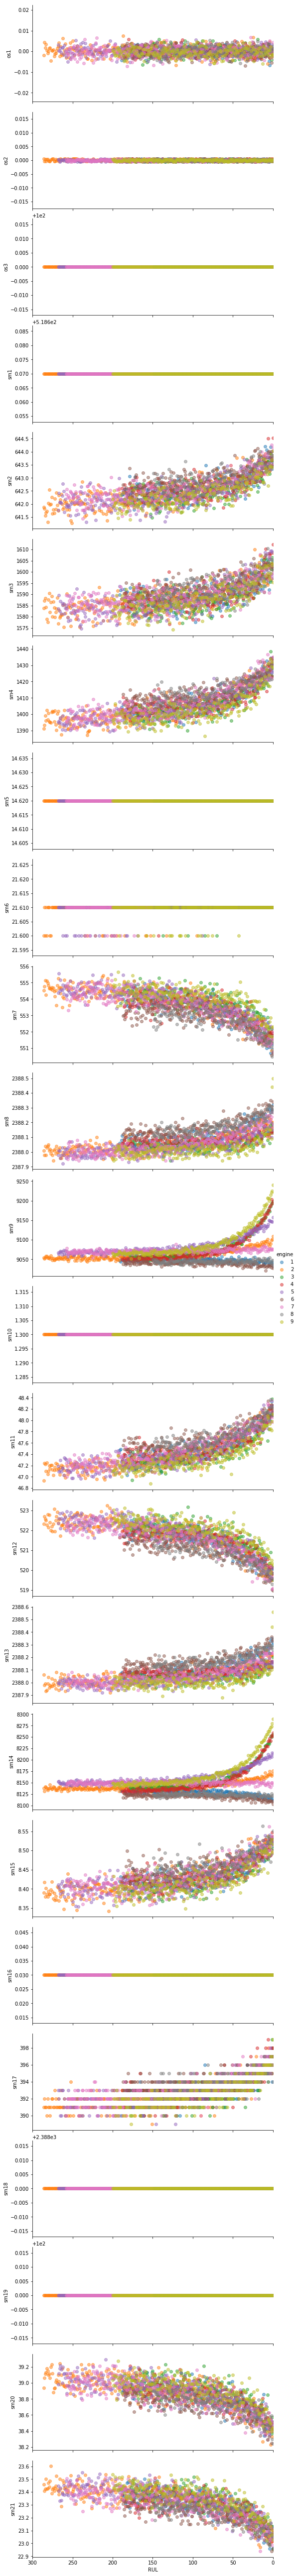

In [9]:
g = sns.PairGrid(data=train_df.query('engine < 10') ,
                 x_vars='RUL',
                 y_vars=["os1","os2","os3","sm1","sm2","sm3",
                    "sm4","sm5","sm6","sm7","sm8","sm9","sm10","sm11",
                    "sm12","sm13","sm14","sm15","sm16","sm17","sm18","sm19",
                    "sm20","sm21"],
                 hue="engine", size=3, aspect=2.5)
g = g.map(plt.scatter, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

In [10]:
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['engine','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

print(train_df.head())

   engine  cycle       os1       os2  os3  sm1       sm2       sm3       sm4  \
0       1      1  0.459770  0.166667  0.0  0.0  0.183735  0.406802  0.309757   
1       1      2  0.609195  0.250000  0.0  0.0  0.283133  0.453019  0.352633   
2       1      3  0.252874  0.750000  0.0  0.0  0.343373  0.369523  0.370527   
3       1      4  0.540230  0.500000  0.0  0.0  0.343373  0.256159  0.331195   
4       1      5  0.390805  0.333333  0.0  0.0  0.349398  0.257467  0.404625   

   sm5     ...      sm16      sm17  sm18  sm19      sm20      sm21  RUL  \
0  0.0     ...       0.0  0.333333   0.0   0.0  0.713178  0.724662  191   
1  0.0     ...       0.0  0.333333   0.0   0.0  0.666667  0.731014  190   
2  0.0     ...       0.0  0.166667   0.0   0.0  0.627907  0.621375  189   
3  0.0     ...       0.0  0.333333   0.0   0.0  0.573643  0.662386  188   
4  0.0     ...       0.0  0.416667   0.0   0.0  0.589147  0.704502  187   

   label1  label2  cycle_norm  
0       0       0     0.00000  
1   

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
train_df.head()

,engine,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm16,sm17,sm18,sm19,sm20,sm21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [22]:
# pick the feature columns 
sensor_cols = ['sm' + str(i) for i in range(1,22)] + 'RUL'
sequence_cols = []

sequence_cols.extend(sensor_cols)
print(sequence_cols)

['sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21']


In [33]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [41]:
data_matrix = train_df[sequence_cols].values

In [44]:
print(data_matrix.shape[1])

21


In [39]:
# Test
batches = get_batches(data_matrix, 50, len(sequence_cols))
x, y = next(batches)


<generator object get_batches at 0x00000207E1838138>


In [ ]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

In [20]:
train_df[train_df['engine']==1].shape

(192, 30)

In [32]:
# pick a large window size of 50 cycles
sequence_length = 30

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['sm' + str(i) for i in range(1,22)] 
sequence_cols.extend(sensor_cols)
print(sequence_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['engine']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['engine']==id], sequence_length, sequence_cols)) 
           for id in train_df['engine'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    data_matrix_ret = data_matrix[seq_length-1:num_elements, :]
    return data_matrix_ret

# generate labels
label_gen = [gen_labels(train_df[train_df['engine']==id], sequence_length, ['RUL']) 
             for id in train_df['engine'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

print("Top")
print(seq_array.shape)
print(seq_array[:5,:])
print(label_array[:5,:])

print("Bottom")
print(label_array.shape)
print(seq_array[-5:,:])
print(label_array[-5:,:])

[[0.         0.18373494 0.40680183 ... 0.         0.71317829 0.7246617 ]
 [0.         0.28313253 0.4530194  ... 0.         0.66666667 0.73101353]
 [0.         0.34337349 0.36952256 ... 0.         0.62790698 0.62137531]
 ...
 [0.         0.73192771 0.61434489 ... 0.         0.27131783 0.23929854]
 [0.         0.64156627 0.68279922 ... 0.         0.24031008 0.32491025]
 [0.         0.70180723 0.66208851 ... 0.         0.26356589 0.09762497]]
192
143


In [14]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

print(nb_features)
print(nb_out)

21
1


In [15]:
train_df.head()

,engine,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm16,sm17,sm18,sm19,sm20,sm21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [12]:
# train_df.drop(['sm1','sm5','sm10','sm16','sm18','os3'], axis=1, inplace=True)

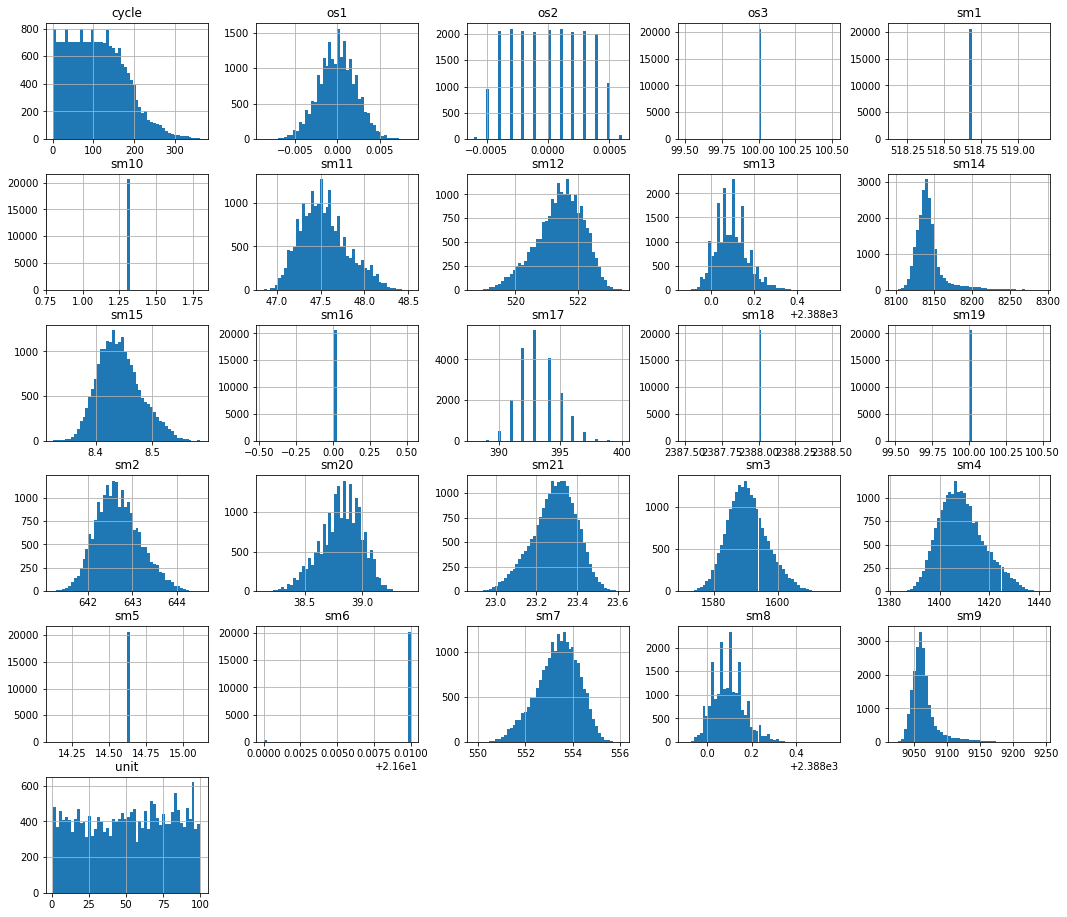

In [22]:
train_df.hist(bins=50, figsize=(18,16))
plt.show()

In [13]:
train_df.groupby('unit').mean()

,cycle,os1,os2,sm2,sm3,sm4,sm6,sm7,sm8,sm9,sm11,sm12,sm13,sm14,sm15,sm17,sm19,sm20,sm21
unit,,,,,,,,,,,,,,,,,,,
1,96.5,-0.000189,4.843750e-05,642.621042,1589.485521,1407.262135,21.610000,553.439427,2388.110260,9048.265833,47.514063,521.459427,2388.110833,8128.913542,8.436555,392.854167,100.0,38.840052,23.306310
2,144.0,0.000051,8.815331e-05,642.435226,1588.181986,1404.265854,21.609338,553.853484,2388.057213,9062.652439,47.389512,521.811603,2388.053554,8143.246167,8.423983,392.386760,100.0,38.901150,23.338997
3,90.0,0.000137,-1.396648e-05,642.543743,1588.715084,1405.628994,21.609777,553.800056,2388.049777,9081.265866,47.427039,521.773966,2388.047430,8159.557654,8.430236,392.754190,100.0,38.882793,23.321931
4,95.0,0.000150,6.719577e-05,642.662381,1590.563280,1408.253915,21.609947,553.443016,2388.079101,9077.366825,47.515132,521.501005,2388.082275,8154.574444,8.439303,393.291005,100.0,38.830265,23.294502
5,135.0,0.000136,-6.059480e-05,642.451970,1588.153271,1404.878439,21.609331,553.882342,2388.034201,9083.948253,47.402268,521.866431,2388.029071,8161.807844,8.425968,392.646840,100.0,38.891078,23.336284
6,94.5,0.000006,-8.650549e-22,642.942340,1592.706277,1413.876117,21.610000,552.790532,2388.175585,9039.279415,47.710372,520.925798,2388.179468,8119.317128,8.458306,393.792553,100.0,38.727447,23.235116
7,130.0,0.000102,-4.980695e-05,642.563320,1589.327838,1406.577336,21.609730,553.650309,2388.060772,9071.470463,47.466564,521.653475,2388.061737,8149.527413,8.433265,392.992278,100.0,38.862124,23.310668
8,75.5,0.000008,2.600000e-05,642.934200,1593.001400,1413.969933,21.610000,552.742600,2388.172733,9044.636133,47.712600,520.898867,2388.170667,8123.167533,8.463234,393.786667,100.0,38.725733,23.228078
9,101.0,-0.000323,4.975124e-06,642.396716,1588.308060,1403.030647,21.609204,554.074030,2388.022786,9093.465174,47.343284,522.031592,2388.014826,8170.726517,8.419438,392.512438,100.0,38.908756,23.353426


In [39]:
grp = train_df.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()

grp.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)

data = train_df.merge(grp, how = 'left', left_on = 'unit', right_on = 'unit')
data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    

In [40]:
data.head()

,unit,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,total_cycles,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187
